# Описание проекта

Решить в каком регионе добывать нефть. Построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль с наименьшим риском убытков.

# 1. Загрузка и подготовка данных

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

... и откроем файлы с данными опробоавния по каждому региону. 

In [2]:
df_region0 = pd.read_csv('/datasets/geo_data_0.csv')
df_region1 = pd.read_csv('/datasets/geo_data_1.csv')
df_region2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_region0.head()
#df_region1.head()
#df_region2.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# df_region0.info()
df_region1.info()
# df_region2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Для каждого региона присутствует 100000 записей с данными опробования скважин. В столбцах присутствует id каждой скважины, три вещественных параметра и итоговое значение объема запасов. 

Интересно заметить, что в каждом регионе некоторые значения id повторяются, например так:

In [5]:
df_region2[df_region2['id']=='VF7Jo']

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


При этом все остальные параетры различаются значительно, так что вряд ли это можно списать на повторные измерения по одной и той же скважине. Скорее всего тут есть ошибка в самом id. В любом случае оно не играет роли в создании модели и дальнейших рассчетах, так что эти столбцы необходимо удалить.

In [6]:
df_region0.drop('id', axis=1, inplace=True)
df_region1.drop('id', axis=1, inplace=True)
df_region2.drop('id', axis=1, inplace=True)

## Комментарий наставника
<span style="color:green">Согласен, решение верное.</span>

Распределение целевого признака по регионам выглядит... не слишком нормально. Особенно для 1 региона.

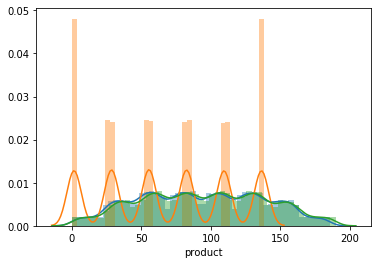

In [7]:
sns.distplot(df_region0['product']);
sns.distplot(df_region1['product']);
sns.distplot(df_region2['product']);

### Вывод

Данные и необходимые библиотеки загружены, пропусков в данных не наблюдается. Столбец с id скважины исключен из рассмотрения. 

# 2. Обучение и проверка модели

Обучим модели для каждого региона в отдельности. 

**0 регион**

В данной работе мы используем линейную регрессию.

Напишем функцию, разделяющую датасет на тренировочную и валидационную часть в соотношении 75:25, обущающую линейную регрессию на тренировочной части, предсказывающую значеня по валидационной, и выводящую на экран средний запас предсказанного сырья и RMSE модели. При этом сохраним в переменные предсказания и правильные ответы на валидационной выборке

In [8]:
def RegionMeanResources(df_region):
    
    region_features = df_region.drop('product', axis=1)
    region_targets = df_region['product']
    
    region_features_train, region_features_valid, region_targets_train, region_targets_valid = (
    train_test_split(region_features, region_targets, test_size=0.25, random_state=42))
    
    model = LinearRegression()
    model.fit(region_features_train, region_targets_train)
    
    predictions_reg = model.predict(region_features_valid)
    print("Средний запас предсказанного сырья:", predictions_reg.mean())
    print("RMSE модели:", mean_squared_error(region_targets_valid, predictions_reg)**0.5)
    return region_targets_valid, predictions_reg

In [9]:
region0_true, region0_pred = RegionMeanResources(df_region0)

Средний запас предсказанного сырья: 92.39879990657768
RMSE модели: 37.75660035026169


**1 регион**

In [11]:
region1_true, region1_pred = RegionMeanResources(df_region1)

Средний запас предсказанного сырья: 68.71287803913764
RMSE модели: 0.8902801001028828


**2 регион**

In [12]:
region2_true, region2_pred = RegionMeanResources(df_region2)

Средний запас предсказанного сырья: 94.77102387765939
RMSE модели: 40.145872311342174


### Вывод

Средний запас предсказанного сырья в первом регионе значительно меньше чем в нулевом и в первом, однако величина ошибки значений при этом значительно меньше. (лично я нахожу это странным, ведь если смотреть на график распределения разброс у 1 региона долже быть как раз таки значительным, ведь там присутствует множество скважин вообще без нефти, и множество с большими запасами, при том что в остальных регионах они распределены практически нормально)

# 3. Подготовка к расчёту прибыли

Сохраним необходимые для рассчета параметры в соответствующих переменных.

In [13]:
budget = 10000000 # бюджет на разработку тыс.руб
income = 450 # доход с единицы продукта тыс.руб
borehole_res = 500 # количество исследуемых скважин
borehole_cnt = 200 # количество выбираемых скважин

Достаточный объём сырья для безубыточной разработки:

In [14]:
sufficient_volume = budget / (income * borehole_cnt)

In [15]:
sufficient_volume

111.11111111111111

### Вывод

Для безубыточной добычи необходимо чтобы в среднем в каждой скважине находилось 111.1 тысяч баррелей нефти. Эта величина больше, чем среднее количество нефти в скважинах по любому из регионов. Поэтому необходимо внимательно отнестись к выбору лучших скважин для разработки.

# 4. Расчёт прибыли и рисков 

Напишем функцию для определения прибыли, в которой отсортируем исследованые скважины по убыванию объемов запасов и выдберем заданное количество скважин для рассчета. 

In [16]:
def Revenue(predict, true, count, income):
    predict_sorted = predict.sort_values(ascending=False)[:count].index
    selected_true = true[list(set(predict_sorted))]
    return income * selected_true.sum()

In [25]:
test_pred = pd.Series(region0_pred)
test_true = pd.Series(region0_true).reset_index(drop=True)

test_pred_sample = test_pred.sample(n=borehole_res, replace=True, random_state=12345)
test_true_sample = test_true[test_pred_sample.index]

predict_sorted = test_pred_sample.sort_values(ascending=False)[:200].index

selected_true = test_true_sample[list(set(predict_sorted))]
selected_true


9218     126.036168
19461    126.700331
6149      65.416249
519      176.668233
21516    131.175286
            ...    
11249    153.314643
4086      72.888348
4601     159.783653
12282    151.889357
3071     139.562000
Name: product, Length: 200, dtype: float64

In [26]:
selected_true = test_true_sample.loc[predict_sorted][:200]
selected_true

17668    123.665790
6823     154.105092
15568    156.667454
4174     126.960826
519      176.668233
            ...    
1682      34.260434
11360     70.944615
22668     84.011794
21567    123.479169
18825     50.690122
Name: product, Length: 200, dtype: float64

Определять доверительный интервал и риск убытков будет с помощью bootstrap'a. Напишем для этого функцию. Из всех предсказанных значений запасов скважин мы 1000 раз выберем по 500 исследуемых, из которых выделим 200 с наибольшими запасами, по которым в итоге посчитаем прибыль и доверительный интервал. Так же вероятность убытков будет показывать 2.5% квантиль. Если его значение будет меньше 0 - значит риск убытков велик, если же больше - значит риск получить убытки меньше 2.5%

In [19]:
def Bootstrap(predict, true, borehole_res, borehole_cnt, income, budget):
    state = np.random.RandomState(12345)
    predict = pd.Series(predict)
    true = pd.Series(true).reset_index(drop=True)
    values = []
    for i in range(1000):
        predict_subsample = predict.sample(n=borehole_res, replace=True, random_state=state)
        true_subsample = true[predict_subsample.index]
        values.append(Revenue(predict_subsample, true_subsample, borehole_cnt, income))
    values = pd.Series(values) - budget
    print('Средняя прибыль:', values.mean())
    print('95% доверительный интервал для прибыли: [{}, {}]'.format(values.quantile(0.025), values.quantile(0.975)))
    print('Вероятность убытков:', (values<=0).mean())

Выполним рассчет прибыли для каждого региона.

**0 регион**

In [20]:
Bootstrap(region0_pred, region0_true, borehole_res, borehole_cnt, income, budget)

Средняя прибыль: 406924.99168124556
95% доверительный интервал для прибыли: [-117742.13649486912, 911737.0507514038]
Вероятность убытков: 0.067


**1 регион**

In [21]:
Bootstrap(region1_pred, region1_true, borehole_res, borehole_cnt, income, budget)

Средняя прибыль: 433149.2850044205
95% доверительный интервал для прибыли: [16846.174932430076, 815972.5262857486]
Вероятность убытков: 0.019


**2 регион**

In [22]:
Bootstrap(region2_pred, region2_true, borehole_res, borehole_cnt, income, budget)

Средняя прибыль: 377557.88467178284
95% доверительный интервал для прибыли: [-170780.41770572757, 901772.1313864449]
Вероятность убытков: 0.074


### Вывод

По результатам бутстрепа видно что регионы значительно отличаются. 0 и 2 регион мы отбрасываем из рассмотрения, так как вероятность убытков в них превышает 2,5%. У 1 региона средняя прибыль больше чем в остальных, однако верхняя граница доверительного интервала возможной прибыли меньше. В остальных регионах высока вероятность получить значительно меньшую прибыль. У второго региона средняя прибыль меньше остальных, и при этом самый большой риск, 7,4%. 

Имеет смысл предложить для разработки 1 регион. Он имеет наибольшую среднюю прибыль и вероятность убытков в нем при этом достаточно мала.

# Итоговый вывод

Был произведен анализ предложеных регионов месторождений с использованием техники bootstrap. В качестве региона для разработки предлагается выбрать 1 регион. Средняя ожидаемая прибыль в нем достаточно высока и равна 433149 тысячам рублей. 95% доверительный интеравал [16846 тыс.руб., 815972 тыс.руб.] Вероятность убытков 1.9%